# Business Analytics (A)
### Pricing NBA Arena Seats Data Sources: Secondary Market Ticket Sales 
### Focus areas: Supervised ML, Ticket Pricing, Presentation and Communication

§ Each NBA team has to price thousands of single game tickets for 41 home games and then update the price in real time to align with the secondary market.

§ Given anonymized historical ticket prices, matchup info and seat location calculate a seat quality score.

§ Use the seat quality score and given market data to assign the optimal ticket price to unsold inventory.

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from bokeh.plotting import figure, save
from bokeh.models import ColumnDataSource
from pandas_profiling import ProfileReport

In [48]:
listing = pd.read_csv("2024-03-06 Listing Data.csv")
location = pd.read_csv("2024-03-06 Seat Coordinates.csv")

In [49]:
listing.head()

,GAME_ID,GAME_DATE,GAME_TIME,SEASON_ID,SEASON_STAGE,VISITOR_TEAM_TRI_CODE,HOME_TEAM_TRI_CODE,SECTION_CATEGORY,SECTION_GROUP,SECTION_LEVEL,SECTION_NAME,ROW_NAME,SEAT_NAME,SECTION_ROW_SEAT_NAME,TICKET_LISTING_PRICE,DAYS_INVENTORY_LEAD_TIME,INVENTORY_LEAD_TIME_CATEGORY
0,22200002,2022-10-18,19:00:00,2022,REGULAR SEASON,LAL,GSW,PREMIUM,LOWER BOWL,LEVEL 100,SECTION 104,ROW 16,SEAT 11,SECTION 104 - ROW 16 - SEAT 11,613.0,0.0,EVENT DAY
1,22200002,2022-10-18,19:00:00,2022,REGULAR SEASON,LAL,GSW,PREMIUM,LOWER BOWL,LEVEL 100,SECTION 124,ROW 26,SEAT 2,SECTION 124 - ROW 26 - SEAT 2,480.0,0.0,EVENT DAY
2,22200002,2022-10-18,19:00:00,2022,REGULAR SEASON,LAL,GSW,PREMIUM,LOWER BOWL,LEVEL 100,SECTION 124,ROW 20,SEAT 3,SECTION 124 - ROW 20 - SEAT 3,470.0,0.0,EVENT DAY
3,22200002,2022-10-18,19:00:00,2022,REGULAR SEASON,LAL,GSW,PREMIUM,LOWER BOWL,LEVEL 100,SECTION 114,ROW 11,SEAT 8,SECTION 114 - ROW 11 - SEAT 8,595.0,0.0,EVENT DAY
4,22200002,2022-10-18,19:00:00,2022,REGULAR SEASON,LAL,GSW,NON-PREMIUM,UPPER BOWL,LEVEL 200,SECTION 221,ROW 21,SEAT 8,SECTION 221 - ROW 21 - SEAT 8,300.0,0.0,EVENT DAY


In [50]:
listing.describe()

,GAME_ID,SEASON_ID,TICKET_LISTING_PRICE,DAYS_INVENTORY_LEAD_TIME
count,4.591590e+05,459159.000000,459159.000000,459159.000000
mean,2.224909e+07,2022.485037,257.129651,17.848608
std,4.994904e+04,0.499777,336.291205,25.554693
min,2.220000e+07,2022.000000,0.000000,0.000000
25%,2.220057e+07,2022.000000,106.000000,0.000000
50%,2.220116e+07,2022.000000,169.000000,6.000000
75%,2.230050e+07,2023.000000,290.000000,25.000000
max,2.230121e+07,2023.000000,20000.000000,120.000000


In [51]:
listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459159 entries, 0 to 459158
Data columns (total 17 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   GAME_ID                       459159 non-null  int64  
 1   GAME_DATE                     459159 non-null  object 
 2   GAME_TIME                     459159 non-null  object 
 3   SEASON_ID                     459159 non-null  int64  
 4   SEASON_STAGE                  459159 non-null  object 
 5   VISITOR_TEAM_TRI_CODE         459159 non-null  object 
 6   HOME_TEAM_TRI_CODE            459159 non-null  object 
 7   SECTION_CATEGORY              459063 non-null  object 
 8   SECTION_GROUP                 459159 non-null  object 
 9   SECTION_LEVEL                 459159 non-null  object 
 10  SECTION_NAME                  459159 non-null  object 
 11  ROW_NAME                      459159 non-null  object 
 12  SEAT_NAME                     459159 non-nul

In [60]:
listing['GAME_DATE'] = pd.to_datetime(listing['GAME_DATE'])
listing['GAME_TIME'] = pd.to_datetime(listing['GAME_TIME'])
listing['SEASON_STAGE'] = listing['SEASON_STAGE'].astype('category').cat.codes
listing['VISITOR_TEAM_TRI_CODE']= listing['VISITOR_TEAM_TRI_CODE'].astype('category').cat.codes
listing['HOME_TEAM_TRI_CODE']= listing['HOME_TEAM_TRI_CODE'].astype('category').cat.codes
listing['SECTION_CATEGORY']= listing['SECTION_CATEGORY'].astype('category').cat.codes
listing['SECTION_GROUP']= listing['SECTION_GROUP'].astype('category').cat.codes
listing['SECTION_LEVEL']= listing['SECTION_LEVEL'].astype('category').cat.codes
listing['SECTION_NAME']= listing['SECTION_NAME'].astype('category').cat.codes
listing['ROW_NAME']= listing['ROW_NAME'].astype('category').cat.codes
listing['SEAT_NAME']= listing['SEAT_NAME'].astype('category').cat.codes
listing['INVENTORY_LEAD_TIME_CATEGORY']= listing['INVENTORY_LEAD_TIME_CATEGORY'].astype('category').cat.codes

/var/folders/1p/n1yg43r91032z6dwjfvfltz00000gn/T/ipykernel_87397/644324318.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  listing['GAME_TIME'] = pd.to_datetime(listing['GAME_TIME'])


In [36]:
profile = ProfileReport(listing, 
                        title='Pandas Profiling Report',
                        html={'style':{'full_width':True}},
                       minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
location.head()

,HOME_TEAM_TRI_CODE,SECTION_ROW_SEAT_NAME,SEAT_CENTER_X,SEAT_CENTER_Y
0,GSW,BALCONY 1 - ROW 01 - SEAT 1,134,2220
1,GSW,BALCONY 1 - ROW 01 - SEAT 2,134,2244
2,GSW,BALCONY 1 - ROW 01 - SEAT 3,134,2268
3,GSW,BALCONY 1 - ROW 01 - SEAT 4,134,2292
4,GSW,BALCONY 2 - ROW 01 - SEAT 1,134,2796


In [61]:
listing.isna().sum()

GAME_ID                         0
GAME_DATE                       0
GAME_TIME                       0
SEASON_ID                       0
SEASON_STAGE                    0
VISITOR_TEAM_TRI_CODE           0
HOME_TEAM_TRI_CODE              0
SECTION_CATEGORY                0
SECTION_GROUP                   0
SECTION_LEVEL                   0
SECTION_NAME                    0
ROW_NAME                        0
SEAT_NAME                       0
SECTION_ROW_SEAT_NAME           0
TICKET_LISTING_PRICE            0
DAYS_INVENTORY_LEAD_TIME        0
INVENTORY_LEAD_TIME_CATEGORY    0
dtype: int64

In [62]:
 %matplotlib inline 

Text(0, 0.5, 'Frequency')

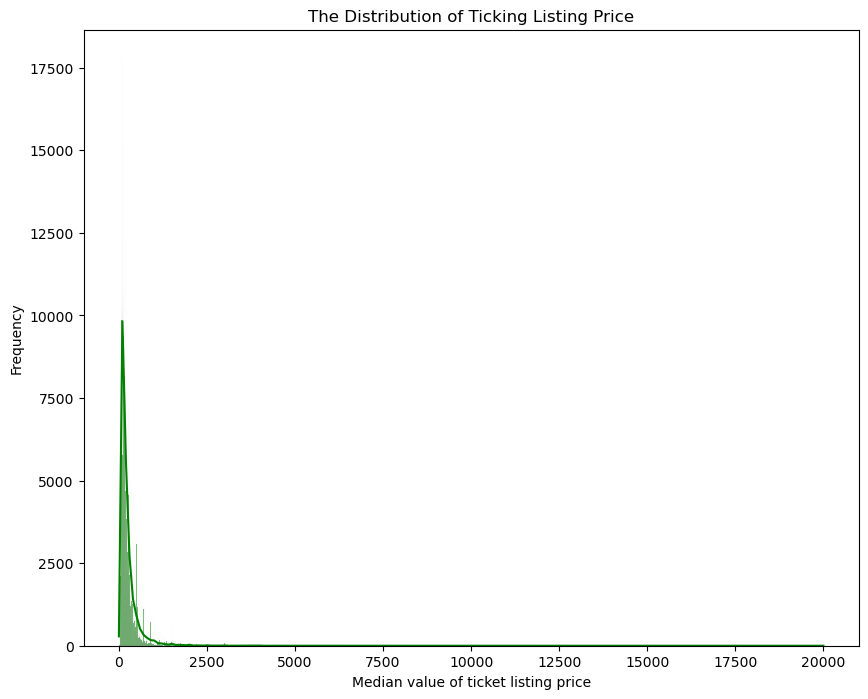

In [63]:
plt.figure(figsize=(10,8))
sns.histplot(listing["TICKET_LISTING_PRICE"], kde=True,color="green")
plt.title("The Distribution of Ticking Listing Price")
plt.xlabel("Median value of ticket listing price")
plt.ylabel("Frequency")

Text(0.5, 1.0, 'The Distribution of Ticket Listing Price')

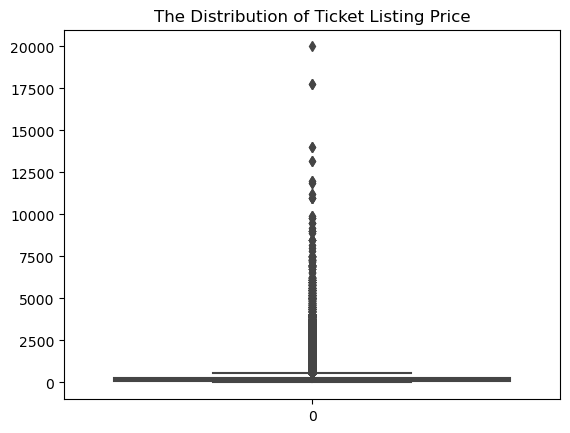

In [64]:
sns.boxplot(listing["TICKET_LISTING_PRICE"], palette="rocket")
plt.title ("The Distribution of Ticket Listing Price")

In [85]:
listing["TICKET_LISTING_PRICE"].describe()

count    459159.000000
mean        257.129651
std         336.291205
min           0.000000
25%         106.000000
50%         169.000000
75%         290.000000
max       20000.000000
Name: TICKET_LISTING_PRICE, dtype: float64

Notably, the max value of $20,000 is an outlier in the ticket listing price. The question is whether this is a valid ticket price, or whether it is an error in data collection. 

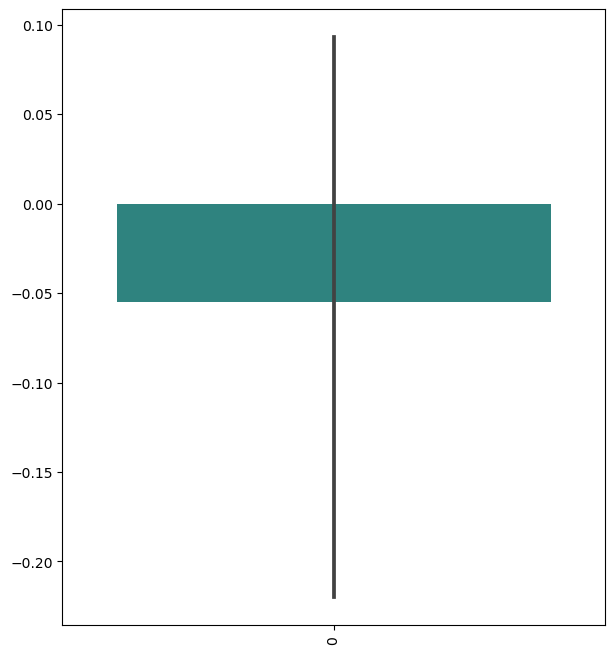

SECTION_GROUP                  -0.629067
SECTION_LEVEL                  -0.437737
SECTION_NAME                   -0.108441
INVENTORY_LEAD_TIME_CATEGORY   -0.069583
VISITOR_TEAM_TRI_CODE          -0.035484
SEASON_ID                      -0.018894
GAME_ID                        -0.018889
SEAT_NAME                       0.026057
DAYS_INVENTORY_LEAD_TIME        0.086372
ROW_NAME                        0.232919
SECTION_CATEGORY                0.367135
SEASON_STAGE                         NaN
HOME_TEAM_TRI_CODE                   NaN
Name: TICKET_LISTING_PRICE, dtype: float64


In [65]:
correlated = listing.corr(numeric_only=True) ["TICKET_LISTING_PRICE"]. sort_values().drop(index="TICKET_LISTING_PRICE")
plt.figure(figsize=(7,8), dpi=100)
sns.barplot(data=correlated,palette="viridis")
plt.xticks(rotation=90)
plt.show()
print(correlated)

### Graph of the average price of each section of seats over time

In [89]:
section_price = listing.groupby('SECTION_NAME')['TICKET_LISTING_PRICE'].mean()

In [99]:
section_price = listing.groupby(['SECTION_NAME', 'DAYS_INVENTORY_LEAD_TIME']).TICKET_LISTING_PRICE.mean()

In [100]:
section_price

SECTION_NAME  DAYS_INVENTORY_LEAD_TIME
0             0.0                           172.4
              1.0                           251.0
              2.0                           161.2
              3.0                           131.0
              4.0                           149.5
                                           ...   
76            97.0                         1600.0
              104.0                        6000.0
              112.0                        2002.0
              117.0                       17777.0
              119.0                        6000.0
Name: TICKET_LISTING_PRICE, Length: 7202, dtype: float64

In [101]:
section_price = section_price.unstack(level='SECTION_NAME')

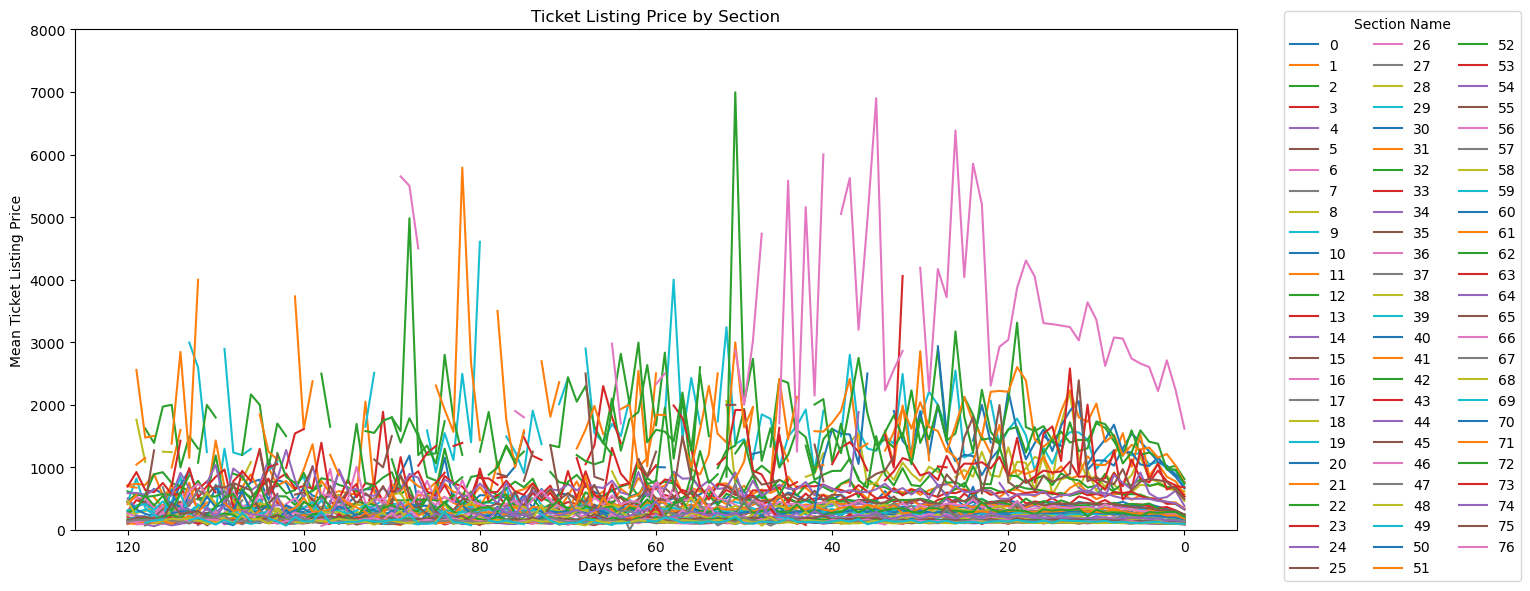

In [178]:
fig, ax = plt.subplots(figsize=(15, 6.5))
ax.plot(section_price)

ax.set_xlabel('Days before the Event')
ax.set_ylabel('Mean Ticket Listing Price')
ax.set_ylim([0, 8000])
ax.invert_xaxis()
plt.title('Ticket Listing Price by Section')

ax.legend(section_price.columns, title="Section Name", loc='upper right', bbox_to_anchor=(1.25, 1.05), ncol=3)

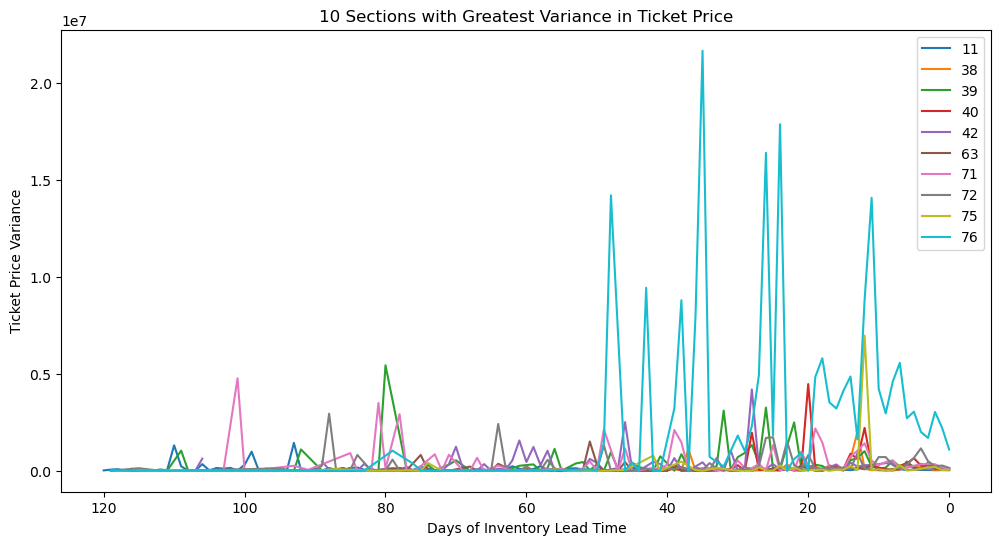

In [173]:
variance_df = listing.groupby(['SECTION_NAME', 'DAYS_INVENTORY_LEAD_TIME'])['TICKET_LISTING_PRICE'].var().reset_index()

sorted_sections = variance_df.groupby('SECTION_NAME')['TICKET_LISTING_PRICE'].mean().sort_values(ascending=False)

top_sections = sorted_sections.head(10).index

top_df = variance_df[variance_df['SECTION_NAME'].isin(top_sections)]

plt.figure(figsize=(12, 6))
for section, data in top_df.groupby('SECTION_NAME'):
    plt.plot(data['DAYS_INVENTORY_LEAD_TIME'], data['TICKET_LISTING_PRICE'], label=section)

plt.xlabel('Days of Inventory Lead Time')
plt.ylabel('Ticket Price Variance')
plt.gca().invert_xaxis()
plt.title('10 Sections with Greatest Variance in Ticket Price')
plt.legend()
plt.show()

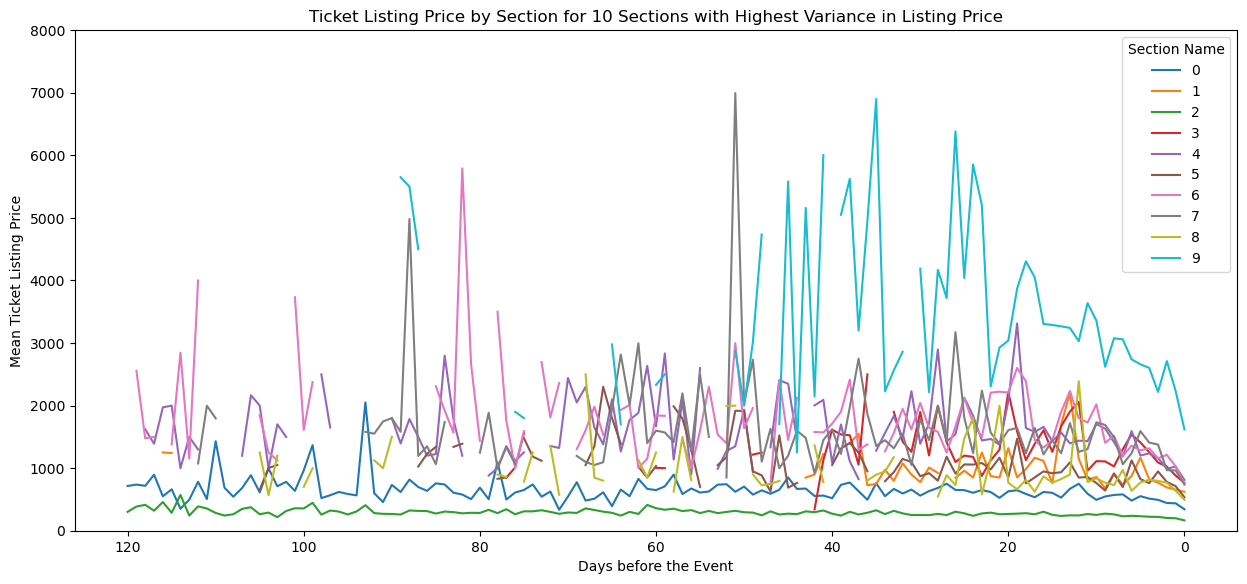

In [191]:
top_variance = section_price[[11, 38, 29, 40, 42, 63, 71, 72, 75, 76]]

fig, ax = plt.subplots(figsize=(15, 6.5))
ax.plot(top_variance)

ax.set_xlabel('Days before the Event')
ax.set_ylabel('Mean Ticket Listing Price')
ax.set_ylim([0, 8000])
ax.invert_xaxis()
plt.title('Ticket Listing Price by Section for 10 Sections with Highest Variance in Listing Price')

ax.legend(section_price.columns, title="Section Name", loc='upper right', bbox_to_anchor=(1, 1), ncol=1)

### Linear Regression Model

In [68]:
X = listing.drop(["TICKET_LISTING_PRICE", 'SECTION_ROW_SEAT_NAME', 'GAME_DATE', 'GAME_TIME'], axis=1)
y = listing["TICKET_LISTING_PRICE"]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [69]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
LR.fit(X_train,y_train)

LinearRegression()

In [71]:
y_pred = LR.predict(X_test)
y_pred

array([220.28374551, 185.82419451, 283.03138131, ...,  73.41042144,
       259.34081144,  79.76184266])

In [75]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
MAE = mean_absolute_error(y_test,y_pred)
MSE = mean_squared_error(y_test,y_pred)
RMSE = np.sqrt(MSE)

print(f"The average of the target variable is {listing['TICKET_LISTING_PRICE'].mean()}")
print(f"Mean Absolute Error Score is {MAE}")
print(f"Mean Squared Error Score is {MSE}")
print(f"Root Mean Squared Error Score is {RMSE}")

The average of the target variable is 257.12965118836826
Mean Absolute Error Score is 112.55497768560811
Mean Squared Error Score is 59146.126118151486
Root Mean Squared Error Score is 243.19976586779742


In [76]:
from sklearn.metrics import r2_score
R_squared = r2_score(y_test,y_pred)
print(f"The R2_score is {R_squared}")

print(f"The Intercept score is {LR.intercept_}")

coef_m = LR.coef_
index_m = LR.feature_names_in_
The_Features = pd.DataFrame(index=index_m,data=coef_m,columns=['The Features']).sort_values(by="The Features")
print(The_Features)

The R2_score is 0.5032359604711618
The Intercept score is -992077.4283395731
                              The Features
SECTION_CATEGORY             -1.093619e+03
SECTION_LEVEL                -9.902208e+02
SECTION_GROUP                -2.739120e+02
INVENTORY_LEAD_TIME_CATEGORY -8.542410e+00
ROW_NAME                     -5.116186e+00
VISITOR_TEAM_TRI_CODE        -1.340593e+00
SECTION_NAME                 -7.789132e-01
GAME_ID                      -5.713615e-03
SEASON_STAGE                 -1.642491e-10
HOME_TEAM_TRI_CODE            3.529976e-11
SEAT_NAME                     1.352319e-02
DAYS_INVENTORY_LEAD_TIME      1.359318e+00
SEASON_ID                     5.550253e+02


### Random Forest Model

In [78]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

In [80]:
# Fitting Random Forest Regression to the dataset
regressor = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)
 
# Fit the regressor with x and y data
regressor.fit(X_train,y_train)

/Users/abigailsnyder/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


RandomForestRegressor(n_estimators=10, oob_score=True, random_state=0)

In [83]:
# Access the OOB Score
oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score}')
 
# Making predictions on the same data or new data
predictions = regressor.predict(X_test)
 
# Evaluating the model
mse = mean_squared_error(y_test,y_pred)
print(f'Mean Squared Error: {mse}')
 
r2 = r2_score(y_test,y_pred)
print(f'R-squared: {r2}')

Out-of-Bag Score: 0.8915430412108538
Mean Squared Error: 59146.126118151486
R-squared: 0.5032359604711618
